In [103]:
import numpy as np
import scipy.ndimage
import cv2
import matplotlib.pyplot as plt
import os
import tifffile
import rasterio
from rasterio.plot import show
import pandas as pd

In [74]:
save_folder = "/data-sat-img/postprocessed/mujiang/sentiel-planet-fusion/prediction/"
cat_list = ["planet_sentinel"]
model_list = ["unet-resnet50-4classes_dice-berhu-_mwca_fusion_23-02-2024_1"]
epoch_list = ["69epoch"]

city = "Shenzhen"

## read and show planet image

In [75]:
planet_path = "/data-sat-img/postprocessed/mujiang/sentiel-planet-fusion/input/predict/planet"
year = "2021"

In [76]:
planet_path = "/data-sat-img/postprocessed/mujiang/sentiel-planet-fusion/input/predict/planet"
planet_tiff = os.path.join(planet_path,city,f"{year}_planet_raster.tif")

# Open the file
with rasterio.open(planet_tiff) as src:
    # Read the raster data
    image = src.read()    
    # Show the image's metadata
    print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 15662, 'height': 7551, 'count': 4, 'crs': CRS.from_epsg(3857), 'transform': Affine(4.777314267160026, 0.0, 12663867.088079073,
       0.0, -4.777314267160045, 2602527.938698478), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


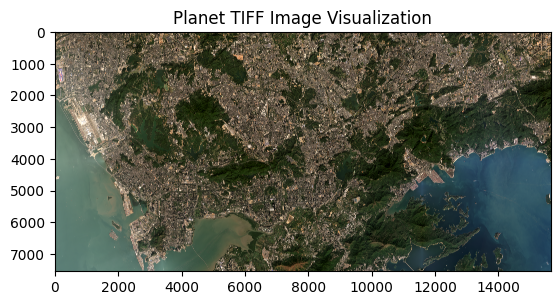

In [77]:
image_rgb = image.transpose((1, 2, 0))

# Visualize the RGB image
plt.imshow(image_rgb)
plt.title('Planet TIFF Image Visualization')
plt.show()

## read predicted building result

In [78]:
i = 0
image_path = os.path.join(save_folder,cat_list[i],model_list[i],epoch_list[i],city)

In [79]:
image = np.asarray(tifffile.imread(os.path.join(image_path,f'{city}_{year}_12_FullPath.tiff'))).astype(np.float32)
image = np.round(image).astype(int)
#image = image[4000:6000,6000:8000]

In [81]:
print(image.shape)

(7551, 15662)


In [84]:
#input_image = image[0:16000,0:16000]
input_image = image[0:7520,0:15600]

# 1. dividing into grid of 200m X 200m

In [86]:
tile_size = 40

reshaped_image = input_image.reshape((input_image.shape[0] // tile_size, tile_size,
                              input_image.shape[1] // tile_size, tile_size))

downsampled_image = reshaped_image.sum(axis=(1, 3))

In [87]:
downsampled_image.shape

(188, 390)

Text(0.5, 1.0, 'downsampled Image')

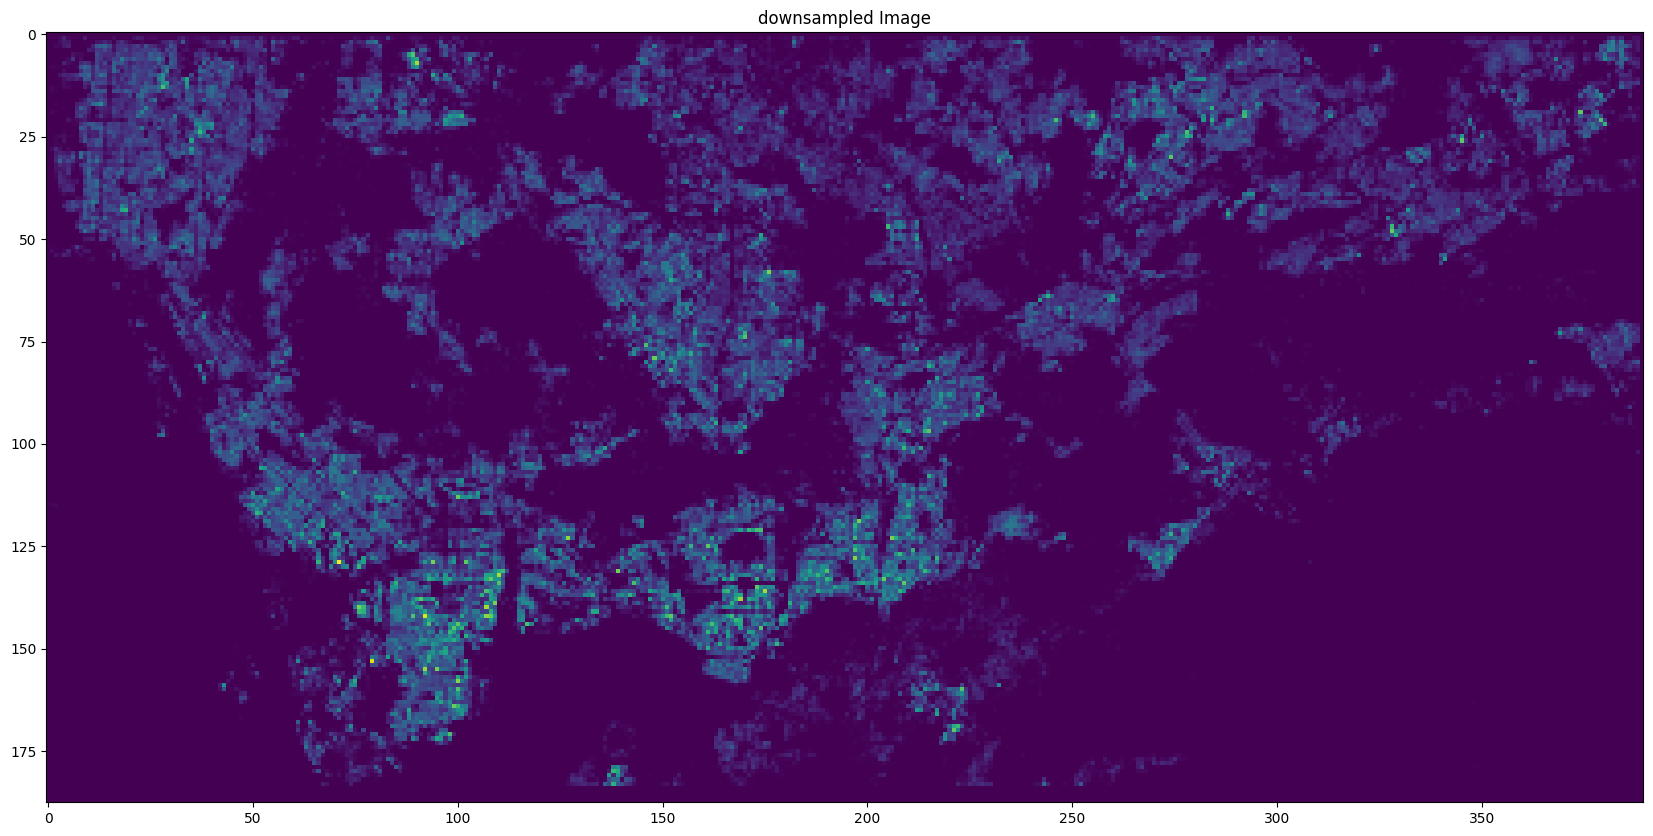

In [88]:
# Display the original and smoothed images using matplotlib
plt.figure(figsize=(30, 10))
plt.imshow(downsampled_image)
plt.title('downsampled Image')

# 2. smoothing the image

In [89]:
def bi_square_kernel_matrix(bandwidth):
    # Determine the size of the kernel matrix
    radius = bandwidth // 2
    kernel_size = radius * 2 + 1
    u = np.linspace(-1, 1, kernel_size)
    
    # Create a meshgrid to compute kernel values for a 2D matrix
    uu, vv = np.meshgrid(u, u)
    radius_sq = uu**2 + vv**2
    kernel_matrix = np.where(radius_sq <= 1, (15/16) * (1 - radius_sq)**2, 0)
    
    # Normalize the kernel matrix
    kernel_matrix /= np.sum(kernel_matrix)
    return kernel_matrix

In [90]:
# Create the bi-square kernel matrix with a given bandwidth
bandwidth = 10  # Adjust based on your needs
kernel_matrix = bi_square_kernel_matrix(bandwidth)

# Apply the kernel to smooth the image
smoothed_image = scipy.ndimage.convolve(downsampled_image, kernel_matrix)

Text(0.5, 1.0, 'smoothed image')

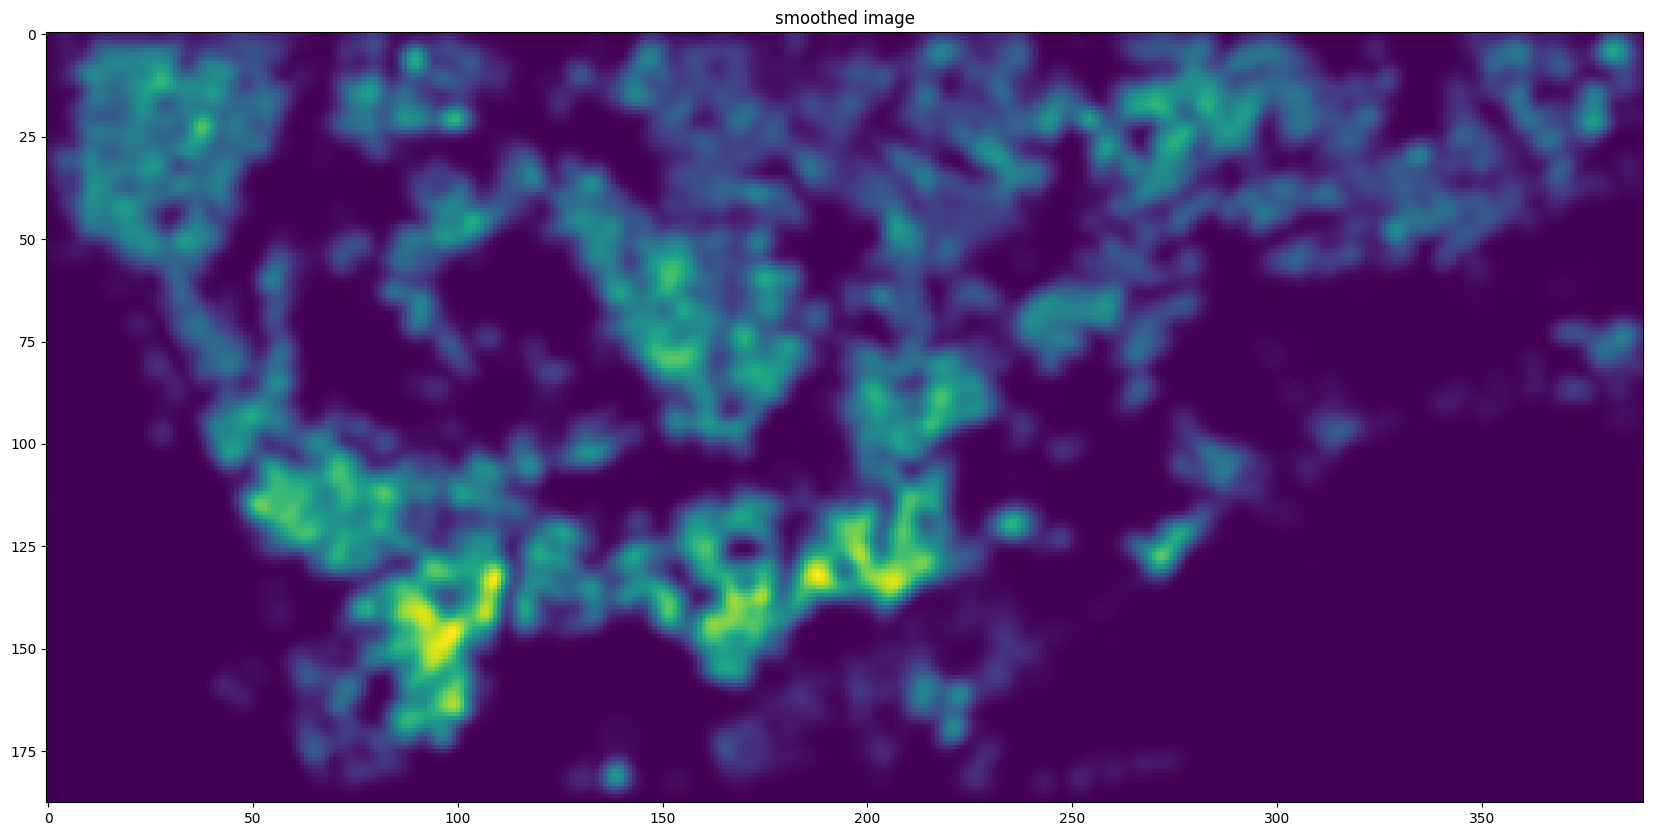

In [91]:
# Display the original and smoothed images using matplotlib
plt.figure(figsize=(30, 10))
plt.imshow(smoothed_image)
plt.title('smoothed image')

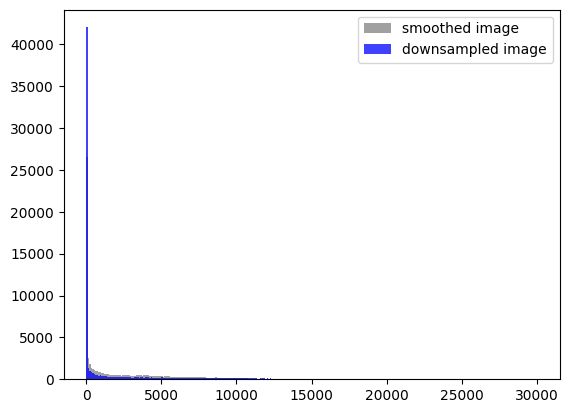

In [92]:
smoothed_image_flatten = smoothed_image.flatten()
downsampled_image_flatten = downsampled_image.flatten()

plt.hist(smoothed_image_flatten, bins=300, range=[0,30000], color='gray', alpha=0.75,label = "smoothed image")
plt.hist(downsampled_image_flatten, bins=300, range=[0,30000], color='blue', alpha=0.75,label = "downsampled image")
plt.legend()
plt.show()

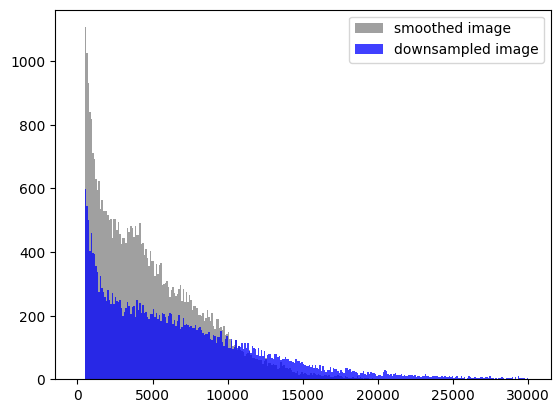

In [93]:
smoothed_image_flatten = smoothed_image[smoothed_image>500].flatten()
downsampled_image_flatten = downsampled_image[downsampled_image>500].flatten()

plt.hist(smoothed_image_flatten, bins=300, range=[0,30000], color='gray', alpha=0.75,label = "smoothed image")
plt.hist(downsampled_image_flatten, bins=300, range=[0,30000], color='blue', alpha=0.75,label = "downsampled image")
plt.legend()
plt.show()

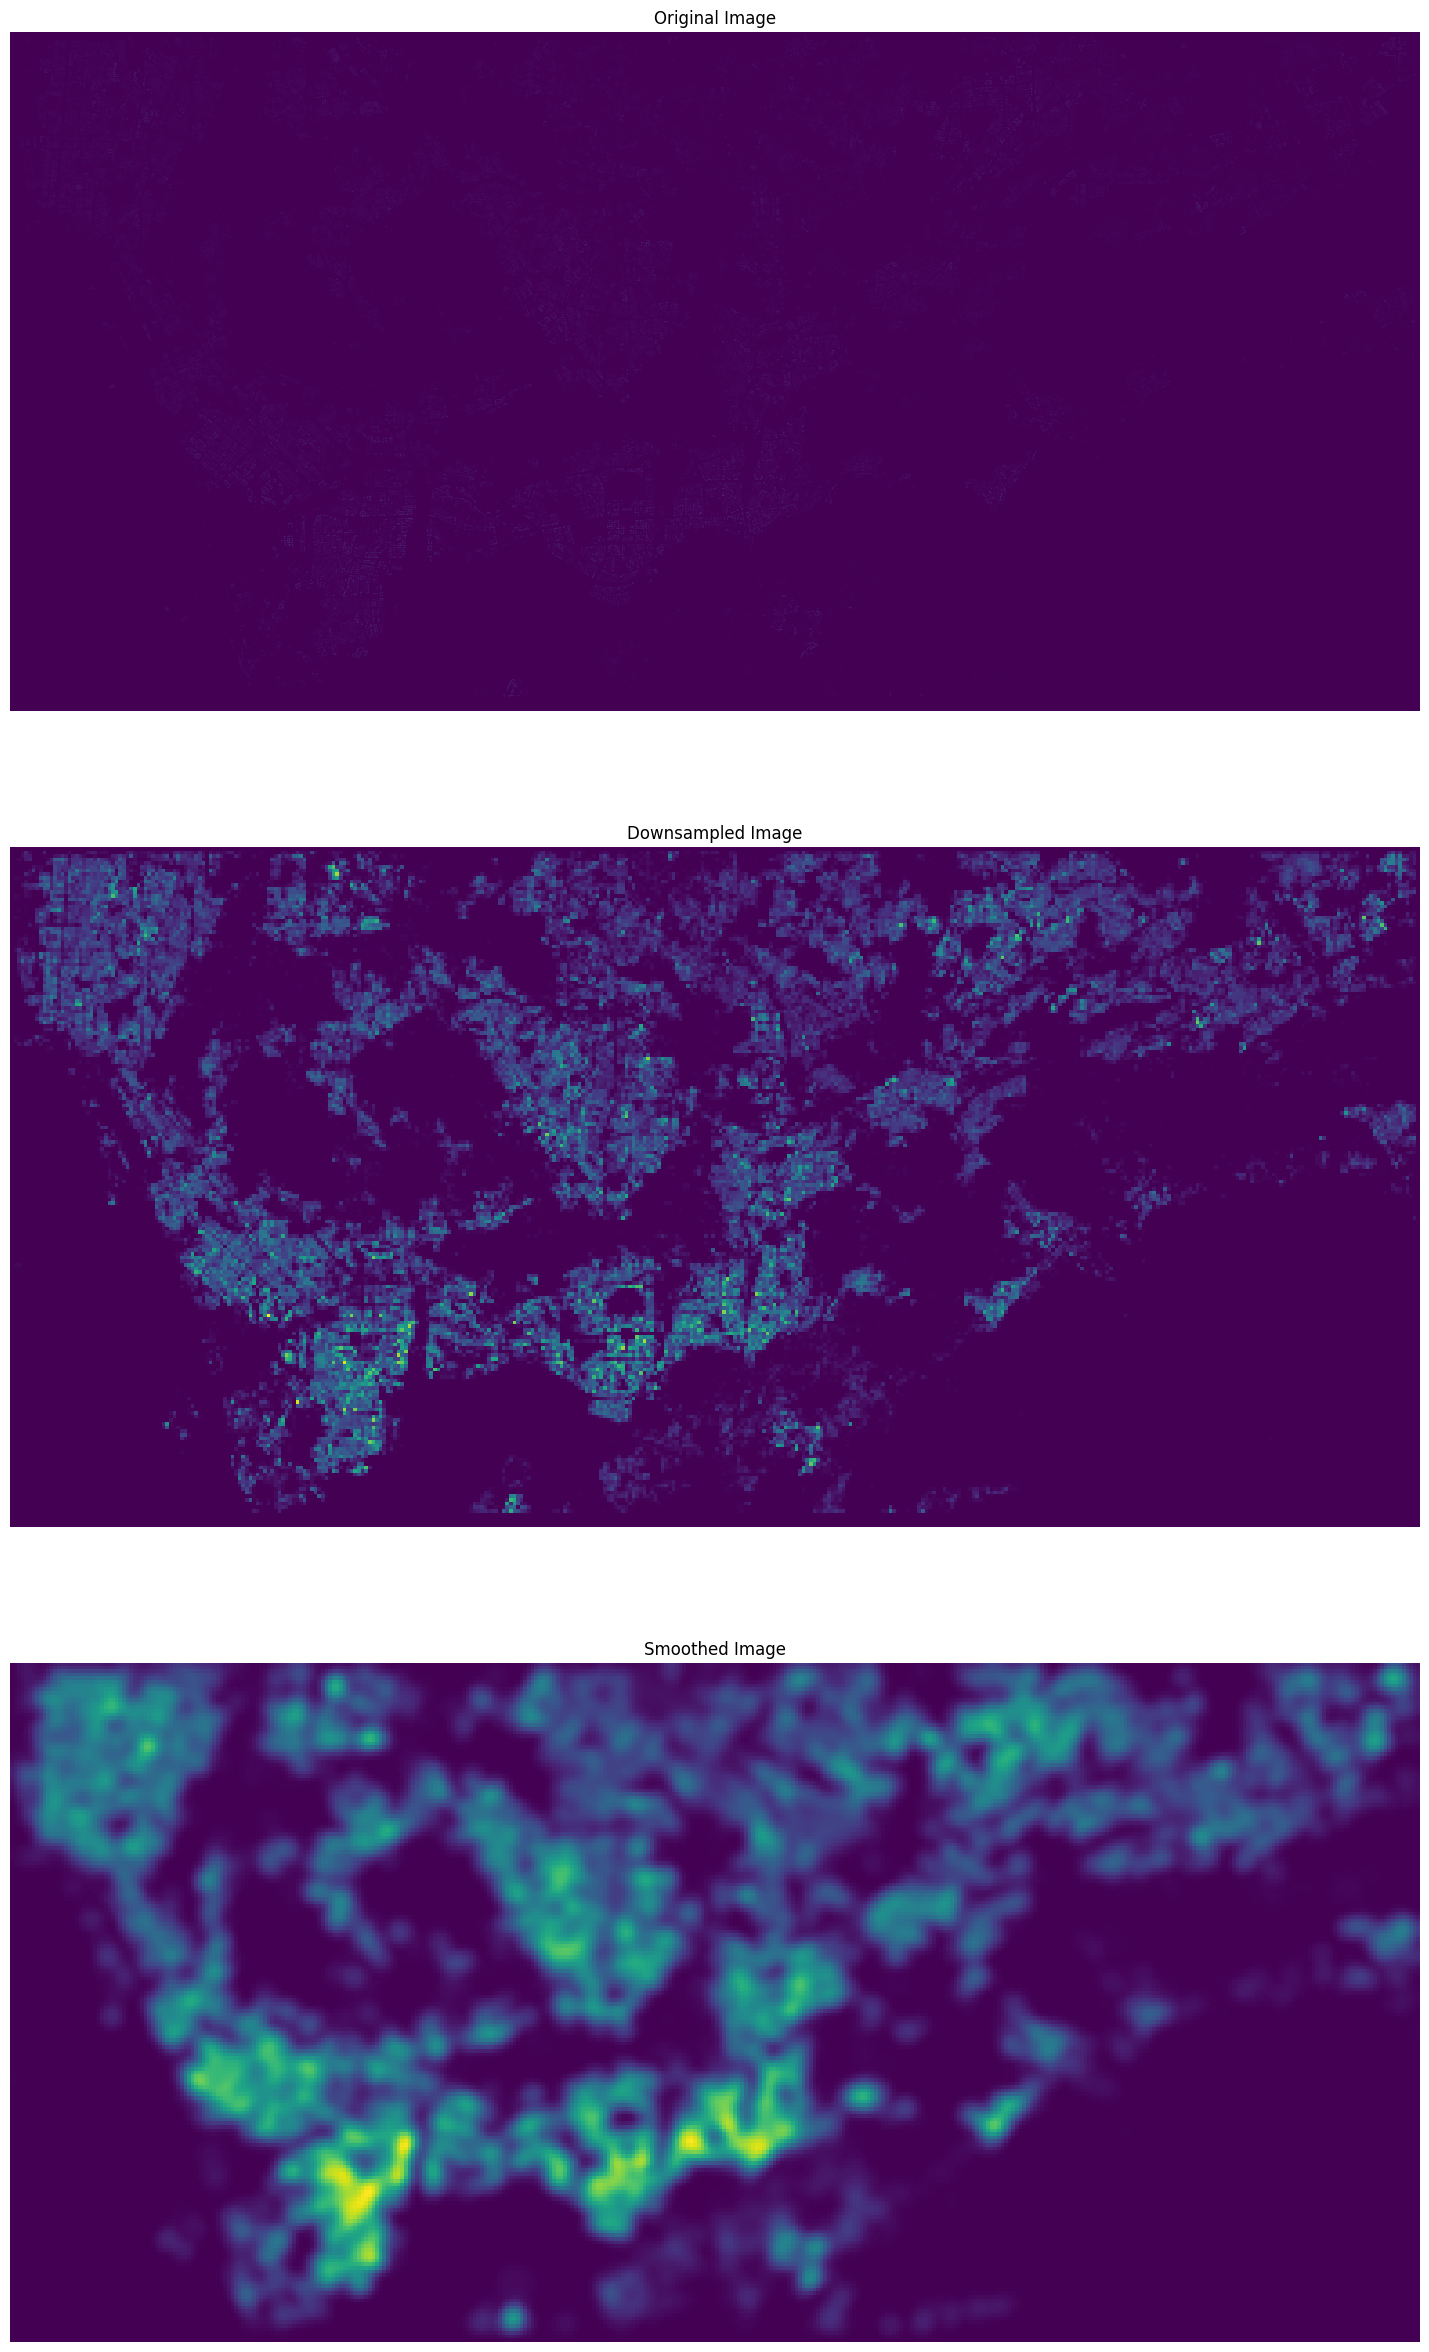

In [94]:
# Display the original and smoothed images using matplotlib
plt.figure(figsize=(30, 30))
plt.subplot(3, 1, 1)
plt.imshow(input_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(3, 1, 2)
plt.imshow(downsampled_image)
plt.title('Downsampled Image')
plt.axis('off')


plt.subplot(3, 1, 3)
plt.imshow(smoothed_image)
plt.title('Smoothed Image')
plt.axis('off')

plt.show()

# calculate gradient and devide into regions

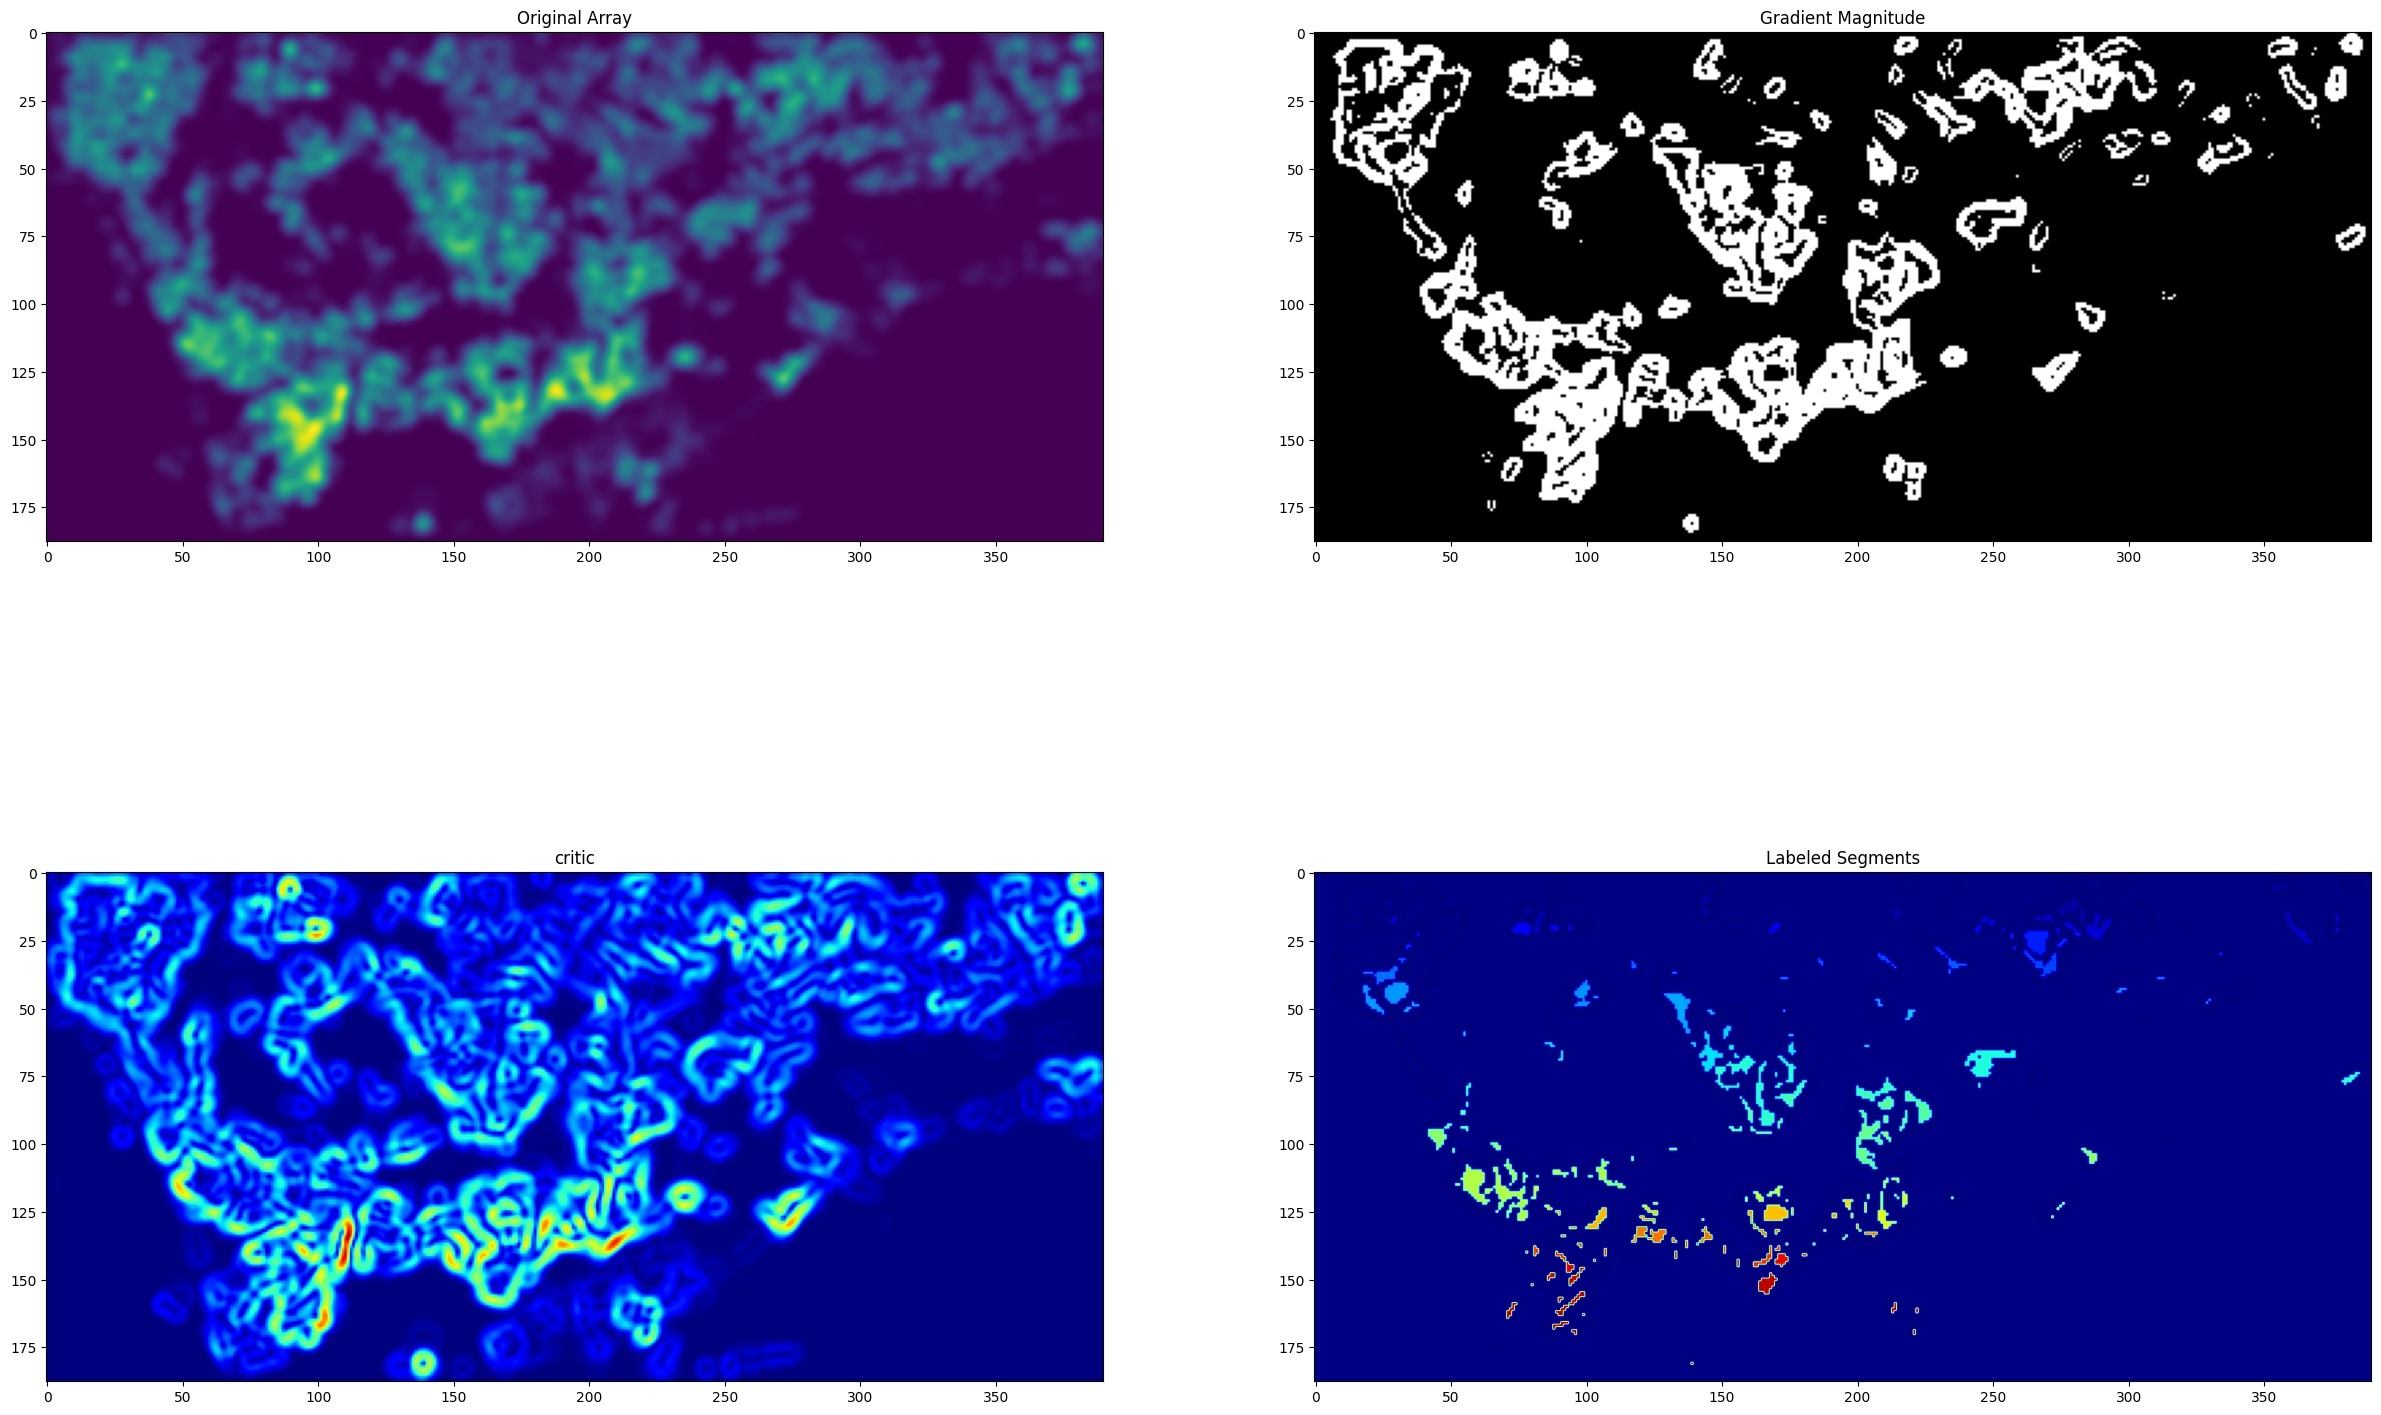

In [95]:
from scipy.ndimage import label


array = smoothed_image
# Calculate gradients
grad_x = np.gradient(smoothed_image, axis=1)  # Gradient along x-axis
grad_y = np.gradient(smoothed_image, axis=0)  # Gradient along y-axis

# Calculate magnitude of gradient
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)

# Define a threshold for high gradient
threshold = grad_magnitude.mean() * 1.2


# Identify high gradient locations
high_grad = grad_magnitude > threshold

#urban area
urban_area = array > 5000

#critic
critic = urban_area * high_grad


# Label regions separated by high gradients
labeled_array, num_features = label(~critic)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(30, 20))
axes[0,0].imshow(array)
axes[0,0].set_title('Original Array')
axes[1,0].imshow(grad_magnitude, cmap='jet')
axes[1,0].set_title('critic')
axes[0,1].imshow(critic, cmap='gray')
axes[0,1].set_title('Gradient Magnitude')
axes[1,1].imshow(labeled_array, cmap='jet')
axes[1,1].set_title('Labeled Segments')
plt.show()

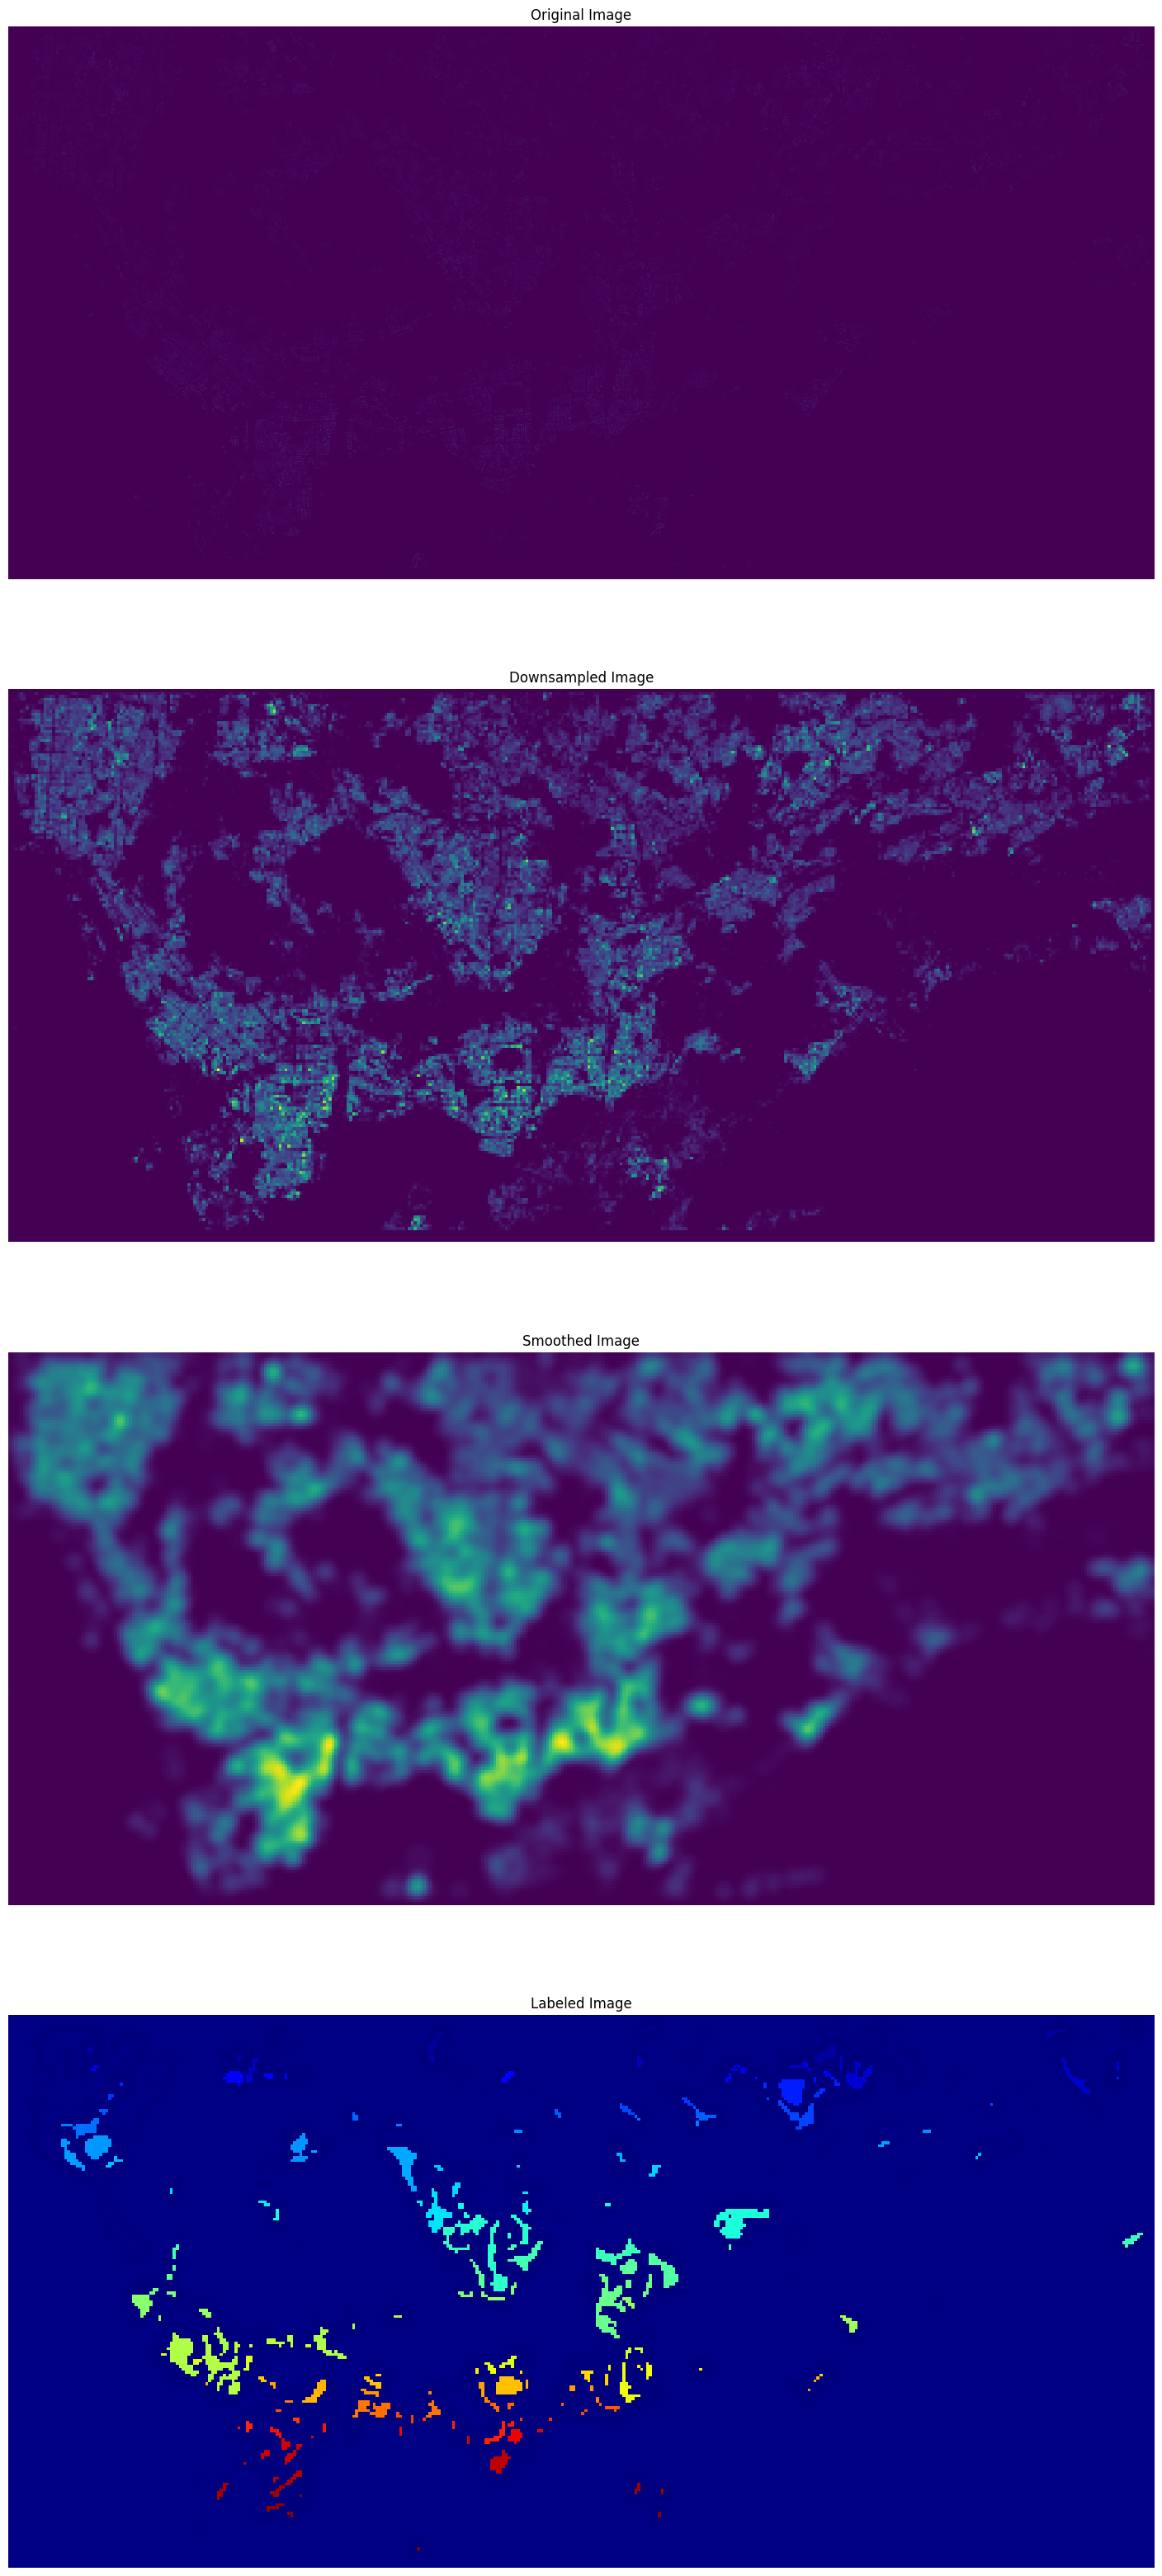

In [96]:
# Display the original and smoothed images using matplotlib
plt.figure(figsize=(30, 40))
plt.subplot(4, 1, 1)
plt.imshow(input_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(4, 1, 2)
plt.imshow(downsampled_image)
plt.title('Downsampled Image')
plt.axis('off')


plt.subplot(4, 1, 3)
plt.imshow(smoothed_image)
plt.title('Smoothed Image')
plt.axis('off')

plt.subplot(4, 1, 4)
plt.imshow(labeled_array, cmap='jet')
plt.title('Labeled Image')
plt.axis('off')

plt.show()

# spatial analysis of POI

In [112]:
city_path = r"/data-sat-img/postprocessed/mujiang/POI/cities/"
poi_summary_path = "/data-sat-img/postprocessed/mujiang/master-thesis/poi_summary/"

In [105]:
geomaster_path = "/data-sat-img/postprocessed/mujiang/geobound_master/"
geomaster = pd.read_csv(geomaster_path + "lookup_table.csv")
geomaster_selected = geomaster[["MID_m","地级","省级"]]

In [106]:
city  = "深圳市"
MID_city = geomaster_selected.loc[geomaster_selected["地级"] == city]["MID_m"].values.min()
MID_city

71

In [107]:
year_list = list(range(2018,2023))
poi_df_list = []

for year in year_list:
    file_path = os.path.join(city_path,f"{MID_city}_{city}",f"{year}_{MID_city}_{city}.csv")
    poi_df_list.append(pd.read_csv(os.path.join(file_path),encoding = "utf-8-sig"))

In [115]:
class1_map = pd.read_csv(poi_summary_path + "class1_map.csv")

poi_df_merged_list = []

for poi_df in poi_df_list: 
    poi_df_merged = pd.merge(poi_df,class1_map,on = "class1",how = "left")
    poi_df_merged_list.append(poi_df_merged)

### create a ID metrics on 200m X 200m scale

In [120]:
grid_map = np.arange(0, downsampled_image.shape[0]*downsampled_image.shape[1])
grid_map = grid_map.reshape(downsampled_image.shape)
grid_map.shape

(188, 390)

In [116]:
pip install pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.4/871.4 kB 11.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
class1_map = pd.read_csv(poi_summary_path + "class1_map.csv")